# Parameter Efficient Tuning of Large Language Models

## Before you start:

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

!pip install transformers datasets
!pip install seaborn umap-learn
!pip install livelossplot
!pip install -q -U datasets==3.6.0 #Supports a previous version for dataset loading
!pip install -q transformers[torch]
!pip install accelerate -U
!pip install -q peft

# Python utils
!pip install -q ipdb      # debugging.
!pip install -q colorama  # print colors :).

import os
import math
import urllib.request

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if os.environ["COLAB_GPU"] and int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()
else:
    print("Only CPU accelerator is connected.")

# https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html#gpu-memory-allocation
# Avoid GPU memory allocation to be done by JAX.
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

import chex
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax

import transformers
from transformers import pipeline, AutoTokenizer, AutoModel
import datasets
import peft

from PIL import Image
from livelossplot import PlotLosses

# Utils.
import colorama

import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import itertools
import random

# download images used in notebook
urllib.request.urlretrieve(
    "https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=80",
    "cat.png",
)

import copy
import huggingface_hub
import ipywidgets as widgets
from IPython.display import display
from datasets import load_dataset
from IPython.display import display, HTML, clear_output
clear_output()

In [ ]:
## Run this cell for helper functions
# @title Run this cell for helper functions.
def print_sample(prompt, sample, model_name="", generation_time=None):
    if prompt in sample:
      sample = sample.split(prompt)[1].rstrip()

    html = f"""
    <div style="font-family:monospace; border:1px solid #ccc; padding:10px">
        <div><b style='color:teal;'>🤖 Model:</b> <span>{model_name}</span></div>
        {'<div><b style="color:orange;">⏱️ Generation Time:</b> ' + f'{generation_time:.2f}s</div>' if generation_time else ''}
        <div><b style='color:green;'>📝 Prompt:</b> {prompt}</div>
        <div><b style='color:purple;'>✨ Generated:</b> {sample}</div>
    </div>
    """
    display(HTML(html))

# From Prompt Engineering to Finetuning

<figure>
  <img src="https://miro.medium.com/v2/resize:fit:1024/1*Qk05I8r-qNA7F_BJSm_wRQ.jpeg" alt="Positional Encoding Vectors" width="650"/>
</figure>

Up to now, you have mostly interacted with language models by either **loading an open-source model locally** using Hugging Face (i.e., performing inference) or by **accessing closed-source models via API calls**. However, out-of-the-box language models may **not be well adapted to specialised tasks or domains** and may require some form of **adaptation** to perform optimally for your specific use case.

For example, consider a scenario where you need to deploy a language model for medical question answering in your local language. A key challenge here is that you may need to equip the model with localised medical and language-specific knowledge it has not encountered during pre-training—especially if you have created a new dataset of question–answer pairs absent from pre-training datasets.

One straightforward way to achieve this is through **prompt engineering**, which involves providing carefully designed prompts that guide the model’s behaviour without modifying its internal weights. The aim is to design prompts that elicit the best possible performance for a given task. You can do this by experimenting with different prompts and selecting the one that achieves the best performance on your validation set.

Examples of prompting techniques include:

* **Zero-shot prompting (Standard Prompting)** – The LLM is given only the task instruction without any examples, relying on its general pre-training to interpret and solve the task ([GPT-3 Paper][], [Zero-Shot Reasoners][]).
* **Few-shot prompting** – A few task examples are included in the prompt to help the model generalise to new inputs ([GPT-3 Paper][]).
* **Chain-of-Thought (CoT) prompting** – Encourages the model to “think step by step” by guiding it to break down its reasoning process ([CoT Paper][]).
* **Tree-of-Thought (ToT) prompting** – Extends CoT by allowing the model to explore multiple reasoning paths in a tree-like structure, then evaluate and select the most promising paths for complex tasks ([ToT Paper][]).

[GPT-3 Paper]: https://arxiv.org/abs/2005.14165
[Zero-Shot Reasoners]: https://arxiv.org/abs/2205.11916
[CoT Paper]: https://arxiv.org/abs/2201.11903
[ToT Paper]: https://arxiv.org/abs/2305.10601

<figure>
  <img src="https://substackcdn.com/image/fetch/$s_!NPw_!,w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F599a636e-b0b2-4de3-84c8-3edf906bfa82_1616x882.png"
       alt="Chain of Thought (CoT) Prompting"
       width="650" />
  <figcaption>
    <em>Example of a Chain-of-Thought (CoT) prompt from Wei&nbsp;et&nbsp;al.,
    “Chain-of-Thought Prompting Elicits Reasoning in Large Language Models,”
    2022.</em>
  </figcaption>
</figure>

For a detailed overview of prompting methods, see the [Prompt Engineering Guide](https://www.promptingguide.ai/) and this blog on [Advanced Prompting Techniques](https://cameronrwolfe.substack.com/p/advanced-prompt-engineering).

---

While prompt engineering can help you extract better performance from an existing model, there are many practical scenarios where fine-tuning an **open-source** model is not just beneficial, but essential. For example:

* **Privacy** – Running and fine-tuning models locally protects sensitive user data (e.g., medical, legal, or financial) that would otherwise be sent to third-party APIs.
* **Computational constraints** – Smaller, optimised models can be fine-tuned and deployed efficiently on edge devices such as mobile phones, Raspberry Pis, or even in-browser via WebAssembly.
* **Domain adaptation** – Tailoring an LLM for a specific domain, such as the medical field in a particular language, using domain-specific datasets.

As you begin exploring fine-tuning, you will find a thriving ecosystem of open-source models in a variety of sizes. It’s important to note the distinction between **open-weight models** and **fully open-source models**. Fully open-source models release not only their weights but also their training dataset recipes, architecture, and code which makes them ideal for experimenting 🧪 with the impact of different design choices, e.g., peeking 👀 into the training data or seeing how model capabilities change 📈 across different checkpoints. An example of the latter is the Olmo range of models.

---

## A Thriving Ecosystem of Open-Source Models

The open-source landscape offers a wide range of models, from compact instruction-tuned models to large, general-purpose LLMs. Examples include:

* [**Phi-3-mini-128k-instruct** (Microsoft)](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct) – 3.8B parameters, trained on synthetic and filtered public data with an emphasis on high-quality, reasoning-dense content.
* [**Phi-4** (Microsoft)](https://huggingface.co/microsoft/phi-4) – A lightweight 14B parameter model optimised for reasoning and code.
* [**Mistral-7B-v0.1** (Mistral AI)](https://huggingface.co/mistralai/Mistral-7B-v0.1) – Transformer architecture with Grouped-Query Attention, Sliding-Window Attention, and Byte-fallback BPE tokenisation.
* [**google/gemma-7b** (Google)](https://huggingface.co/google/gemma-7b) – Decoder-only models focused on alignment and safety, under a permissive licence.
* [**Llama 3** (Meta)](https://huggingface.co/meta-llama) – 8B and 70B parameter models with broad language coverage and strong reasoning performance.
* [**Llama 3.2** (Meta)](https://huggingface.co/meta-llama) – Multilingual pretrained and instruction-tuned models in 1B and 3B sizes.
* [**TinyLlama**](https://huggingface.co/cognitivecomputations/TinyLlama-1.1B-Chat-v1.0) – A 1.1B parameter model trained from scratch, designed for edge deployment.
* [**Qwen/Qwen3-0.6B**](https://huggingface.co/Qwen/Qwen3-0.6B) – The latest generation in the Qwen series, available in dense and mixture-of-experts variants.
* [**gpt-oss-120B & gpt-oss-20B**](https://openai.com/index/introducing-gpt-oss/) – OpenAI’s open-weight models under Apache 2.0 license. The 120B variant runs on an 80 GB GPU; the 20B model can operate on a phone. Both support long context length (up to 131,072 tokens) and are their first open releases since GPT-2.


This variety allows you to:

* Select a model that balances **performance**, **size**, and **deployment cost**
* Apply **parameter-efficient fine-tuning** (e.g., LoRA, adapters) to your needs
* Fully **audit**, **customise**, and **control** the model’s behaviour without reliance on proprietary APIs

---

## Parameter-Efficient Fine-Tuning (PEFT)

In the BERT era, full-model fine-tuning—updating all weights—was feasible on consumer GPUs because models were relatively small. As models have grown in size, full fine-tuning has become impractical for most developers.

Deploying a full copy of each fine-tuned model for each downstream task is also expensive, as each one is as large as the original pretrained model.

**Parameter-Efficient Fine-Tuning (PEFT)** methods address both the cost of training and the expense of deployment by only fine-tuning a small number of additional parameters while freezing the majority of the pretrained model.

Benefits include:

* Substantially reduced **computational** and **storage** costs
* Avoidance of [**catastrophic forgetting**](https://arxiv.org/abs/1312.6211), which can occur in full fine-tuning
* Strong performance in **low-data** scenarios
* Better **generalisation** to out-of-domain tasks

This tutorial will introduce several PEFT methods, including **prefix tuning**, **adapter methods**, and, most notably, **LoRA (Low-Rank Adaptation)**—currently the most widely used approach.

## 1.1 Prefix tuning

Prefix tuning is a parameter-efficient fine-tuning method that adapts a pretrained model by prepending a small number of trainable prefix tokens (embeddings) to the key and value sequences inside the attention mechanism of each transformer layer, rather than modifying the model’s original weights.

<figure>
  <img src="https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FkIRwK%2FbtsIV6C9rN4%2FAAAAAAAAAAAAAAAAAAAAADrciUfx8ZUoGIkW8C_Db9ZaOMcm-k0ncQXFC7hFapPf%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1756652399%26allow_ip%3D%26allow_referer%3D%26signature%3DNg5gJU9nZIOMIWkn9uRUiIHHIl0%253D"
       alt="Prefix Tuning Illustration"
       width="500" />
  <figcaption>
    <em>
      Illustration of prefix tuning from Li&nbsp;and&nbsp;Liang,
      <a href="https://arxiv.org/abs/2101.00190" target="_blank">
        “Prefix-Tuning: Optimizing Continuous Prompts for Generation,” 2021
      </a>.
    </em>
  </figcaption>
</figure>


Unlike prompt engineering, which modifies only the textual input tokens, or full fine-tuning, which updates all the model parameters, prefix tuning freezes the base model and learns a small set of additional parameters—typically less than 0.1% of the total model size.

These prefix tokens are virtual tokens: they don’t correspond to actual words, but instead are trainable vectors that condition the model’s hidden states. They are initialised via an MLP that maps a set of prefix embeddings into the correct dimensionality for each layer’s key and value matrices in the attention mechanism. This was first introduced in the ["Prefix-Tuning: Optimizing Continuous Prompts for Generation" paper](https://arxiv.org/abs/2101.00190) by Xiang Lisa Li and Percy Liang where they showed that by learning only 0.1% of the parameters, prefix-tuning obtains comparable performance to full finetuning and ourperforms fine-tuning in low data settings.


The figure below contrasts a standard transformer block with one enhanced by prefix tuning, showing where the prefix tokens are inserted.
By training only the prefix embeddings and the MLP used to initialise them, you can adapt a model to a new domain with minimal parameter updates—achieving performance close to full fine-tuning at a fraction of the cost.

<img src="https://drive.google.com/uc?export=view&id=1fSnk9MkoPN6KbmbP71iU9EViU9avvOHb" alt="drawing" width="230"/>

Below is pseudo code showing the key differences between a standard transformer block and one with prefix tuning. (Note: this code is illustrative only—it will not run as-is.)

In [ ]:
def normal_transformer_block(tokens):
  """
  Example of pseudo code for a normal transformer.
  """
  original_tokens = tokens
  x = MHA(tokens)
  x = LayerNorm(x + original_tokens)
  original_tokens = x
  x = FF(x)
  transformed_tokens = LayerNorm(x + original_tokens)
  return transformed_tokens

def transformer_block_with_prefix(tokens, trainable_tokens):
  """
  Example of pseudo code of transformer block with prefix tuning.
  """
  prefix = FF(trainable_tokens)  # Trainable MLP and tokens.
  tokens = concat([prefix, tokens]) # Concatenate prefix tokens
  original_tokens = tokens
  x = MHA(tokens)
  x = LayerNorm(x + original_tokens)
  original_tokens = x
  x = FF(x)
  transformed_tokens = LayerNorm(x+original_tokens)
  return transformed_tokens

## 1.2 Adapter Methods

<figure>
  <img src="https://yynnyy.cn/files/images/adpter_tuning/transformer.png"
       alt="Adapter Illustration"
       width="500" />
<figcaption>
  <em>
    Illustration of adapters from
    <a href="https://arxiv.org/abs/1902.00751" target="_blank">
      Houlsby et&nbsp;al., “Parameter-Efficient Transfer Learning for NLP” (2019)
    </a>.
  </em>
</figcaption>
</figure>

Very similar, and introduced in the ["Parameter-Efficient Transfer Learning for NLP" paper](https://arxiv.org/abs/1902.00751) by Houlsby etc, it consists of adding a new block of weights between the transformer blocks called "Adapter". The weights of the original transformer blocks remain untouched, while the new adapter weights are initialized at random. The adapter weights normally have significantly less number of parameters (in practice 0.5 - 8% of the parameters of the original model). During adapter tuning, the green layers are trained on the downstream data, this includes the adapter, the layer normalization parameters, and the final classification layer (not shown in the figure).
It has been shown to achieve similar performance to updating an entire network while only training 3.6% of the total model parameters.

Below again is pseudo code highlighting where and how this work. Note running the code will not work.

**Code exercise**: In similar style implement a pseudo-code implementation of the `Adapter` block showed in the diagram above.

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

def transformer_block_with_adapters(tokens):
  """
  Example of psuedo code of transformer block with adapter layers.
  """

  original_tokens = tokens
  adapted_tokens = AdapterLayer(tokens) # trainable
  x = MHA(adapted_tokens)
  x = LayerNorm(x + original_tokens)
  original_tokens = x
  x = AdapterLayer(x) # trainable
  x = FF(x)
  transformed_tokens = LayerNorm(x+original_tokens)
  return transformed_tokens

To see how both worlds from adapters and prefix tuning are together refer to the [LLAMA-Adapter paper](https://arxiv.org/abs/2303.16199).

## 1.3 LoRA

> This section is a summarized copy of the [LoRA paper]((https://arxiv.org/abs/2106.09685), read the paper for more details! We also recommend beginners to focus more on the finetuning and interacting with your trained model, than on the details presented here.

Finally let's talk about one of the most widely used methods for Efficient FineTuning called LoRA introduced in the paper ["LoRA: Low-Rank Adaptation of Large Language Models"](https://arxiv.org/abs/2106.09685) from Edward J. Hu et al.

The idea behind Parameter Efficient Tunning (PEFT) is how to **efficiently** (memory wise and speedwise ) finetune these large models while significantly improving quality of the outputs produced, or to make the model behave in a different manner.

Also it's important not only to be efficient during the finetune process but also during **inference** (e.g. for text generation models we're usually most interested in sampling time).

[Here](https://thinkingmachines.ai/blog/lora/) is an excellent resource on LoRA.


**Task**: To build intuition for what is to come, prove that $y1$ equal, or not equal, to $y2$. Note, $X$ and $W$ are matrices.

> $W = W_1 + W_2$
>
> $y_1 = WX$
>
> $y_2 = W_1X + W_2X$

In [ ]:
# @title Answer to math task (Try not to run until you've given it a good try!')
%%latex
\begin{aligned}
y_1 &= WX \\
y_1 &= (W_1+W_2)X \\
y_1 &= W_1X+W_2X \\
y_1 &= y_2
\end{aligned}


<IPython.core.display.Latex object>

Large language models like GPT-3 have hundreds of billions of parameters, making full fine-tuning both expensive and memory-intensive. **LoRA** offers a parameter-efficient alternative by fine-tuning only a small set of additional weights while keeping the original model parameters frozen.

---

### 1. Core idea

Let $W_0 \in \mathbb{R}^{d_{\text{out}} \times d_{\text{in}}}$ be a pre-trained weight matrix.
In standard fine-tuning, we would update $W_0$ directly.
In LoRA, we **freeze** $W_0$ and represent the weight change $\Delta W$ as a low-rank factorization:

$$
\Delta W = B A
$$

where:

* $A \in \mathbb{R}^{d_{\text{in}} \times r}$ is a **down-projection** into a rank-$r$ subspace,
* $B \in \mathbb{R}^{r \times d_{\text{out}}}$ is an **up-projection** back to the original dimension,
* $r \ll \min(d_{\text{in}}, d_{\text{out}})$ controls the number of trainable parameters.



<figure>
  <img src="https://drive.google.com/uc?export=view&id=1eGxjTrnkpHxM8VN_SKJLa6yff0gmxJYP"
       alt="Training vs inference compute comparison"
       width="600" />
  <figcaption>
    <em>
      LoRA adds parameters only during training (orange). At inference, \(B A\) is merged into \(W_0\), so compute cost is unchanged.
    </em>
  </figcaption>
</figure>

---


Once $A$ and $B$ are learned, LoRA removes the two-matrix path entirely by **merging** them into the frozen weights:

$$
W_{\text{merged}} = W_0 + (B A)
$$

At inference, the model simply computes:

$$
y = W_{\text{merged}} x
$$

This is identical in cost to the original model — there are no extra multiplications or parameters at runtime. The parameter-efficiency advantage is purely a training-time benefit.

The effective weight during training is:

$$
W = W_0 + \Delta W = W_0 + B A
$$

<figure>
  <img src="https://drive.google.com/uc?export=view&id=1534a4LeyfTSegnm4Dnfxx6_mWB0BMUOZ"
       alt="LoRA factorization concept"
       width="600" />
  <figcaption>
    <em>
      LoRA factorizes the weight update \(\Delta W\) into two smaller matrices \(B\) and \(A\), reducing the number of trainable parameters.
    </em>
  </figcaption>
</figure>

---



### 2. Parameter count and example

For a weight $W_0 \in \mathbb{R}^{d_{\text{out}} \times d_{\text{in}}}$, LoRA adds:

$$
\underbrace{d_{\text{in}} \cdot r}_{A} + \underbrace{r \cdot d_{\text{out}}}_{B}
$$

trainable parameters per layer (plus small biases if used).

**Example:**
Suppose $d_{\text{in}} = d_{\text{out}} = 4096$ and $r = 8$:

* Full weight size: $4096 \times 4096 = 16{,}777{,}216$ parameters.
* LoRA parameters: $4096 \times 8 + 8 \times 4096 = 32{,}768 + 32{,}768 = 65{,}536$ parameters.
* This is **\~256× fewer parameters** to train for that layer.

---
### 3. Forward pass during fine-tuning

For an input vector $x$:

$$
y = W x = W_0 x + B A x
$$

* $W_0$ is fixed and reused from the pre-trained model.
* Only $A$ and $B$ are updated during training.
* This adds minimal memory and compute overhead in training compared to updating $W_0$ directly.

---

### 4. Why low-rank?

LoRA builds on the finding by [Aghajanyan et al. (2020)](https://arxiv.org/abs/2012.13255) that large language models have **low intrinsic dimensionality**:
there exists a low-dimensional reparameterization that can match the performance of full-space fine-tuning.

If the adaptation updates $\Delta W$ lie mostly in a small subspace, then we can restrict $\Delta W$ to have **low intrinsic rank** without losing much accuracy.

This is analogous to PCA or SVD:

* $A$ acts like a projection onto the top $r$ principal components,
* $B$ reconstructs from that subspace back into the original space.

<figure>
  <img src="https://sebastianraschka.com/images/blog/2023/llm-finetuning-lora/pca.png"
       alt="Low-rank projection analogy"
       width="600" />
  <figcaption>
    <em>
      Low-rank factorization is conceptually similar to PCA/SVD, where a small set of basis vectors can represent the full space with minimal loss.  
      Adapted from <a href="https://sebastianraschka.com/blog/2023/llm-finetuning-lora.html" target="_blank">Sebastian Raschka</a>.
    </em>
  </figcaption>
</figure>

---


### 5. Intuitive view

You can think of:

* **$A$** as an *encoder* that projects the input into a compact $r$-dimensional subspace,
* **$B$** as a *decoder* that maps back to the original dimension,
* The LoRA output $B A x$ as a small, targeted correction added to the frozen model output $W_0 x$.


After fine-tuning, $BA$ can be merged into the frozen $W_0$ to form a single updated weight matrix. This means there is no extra computation or memory overhead at inference time — the model runs exactly like the original.
<figure>
  <img src="https://drive.google.com/uc?export=view&id=1Kz68zGJ_9IuZWQ-0tcGaD-Azm5G4GDCW"
       alt="LoRA encoder-decoder interpretation"
       width="600" />
  <figcaption>
    <em>
      LoRA can be seen as adding a lightweight encoder-decoder to each targeted layer, training only these modules while keeping the main weights frozen.
    </em>
  </figcaption>
</figure>


- **Efficient Parameter Adjustment**: Instead of modifying all the original model's parameters (which are numerous and resource-intensive), LoRA introduces trainable rank decomposition matrices into each layer of the Transformer architecture. These matrices have a much smaller size than the original model's weight matrices.
- **Reduced Memory Footprint**: By training only these smaller matrices, LoRA significantly reduces the memory requirements associated with fine-tuning large models.
- **Avoids Catastrophic Forgetting**: The original model's weights remain frozen, and the LoRA matrices capture the task-specific knowledge, allowing the model to adapt to new data or tasks without altering its core capabilities.
- **Merging with the Original Model**: During inference, the low-rank matrices are merged back with the original weights, effectively injecting the learned knowledge into the model.
- **Modularity and Reusability**: The trained LoRA modules can be easily swapped, enabling flexible and efficient adaptation across various tasks.

### 1.3.1 Lora Implementation

Now let's implement a simple LoRA module together!

Before doing so, there're a couple of parameters / configs associated with LoRA:

1. **target\_modules** – Which layers or Transformer matrices (e.g., Q, K, V) to apply LoRA to.
2. **lora\_rank** – The rank $r$ of the low-rank factorization; controls how much capacity the LoRA update has. Typically, **low ranks: 8, 16, 32** and **high ranks: 128, 256**
3. **lora\_alpha** – A scaling factor applied to the low-rank update $\Delta W$ before adding it to $W_0$. It changes how the LoRA's weights are weighed against the base model's. Higher alpha means the LoRA layers act more strongly than the base model. Typically set to **r** or **2 x r**. The original LoRA method uses the scalar function **lora_alpha/r** for scaling LoRA weights during forward pass.

   * Keeps the update magnitude consistent when $r$ changes, reducing the need to re-tune the learning rate.
   * In the LoRA forward pass:

     $$
     y = W_0 x + \frac{\alpha}{r} \,(B A) x
     $$
4. **initialization** – $A$ initialized with small Gaussian noise; $B$ initialized to zero so the model starts identical to $W_0$.
5. **dropout** – Optional dropout applied to the LoRA module during training.

---

**Group task**: Can you think of why the initialization proposed in 4. is used?


In [ ]:
from peft.tuners.lora.layer import Linear
import torch.nn as nn

LORA_R = ...
LORA_ALPHA = ...

class CustomLinearLoRA(Linear):
    """Barebones LoRA: ΔW = (α/r) B A added to frozen base layer."""

    def update_layer(
        self,
        adapter_name,#adapter is a named set of additional parameters that modifies a frozen model.
        r,
        lora_alpha,
        lora_dropout,
        init_lora_weights,
        use_rslora=False,
        use_dora=False,
    ):
        if r <= 0:
            raise ValueError(f"`r` must be > 0, got {r}")

        # Store LoRA config
        self.r[adapter_name] = r
        self.lora_alpha[adapter_name] = lora_alpha

        # TODO: Define a dropout module for LoRA path
        lora_dropout_layer = ...
        self.lora_dropout.update(nn.ModuleDict({adapter_name: lora_dropout_layer}))

        # TODO: Define LoRA A (d_in -> r) and B (r -> d_out) linear layers
        self.lora_A[adapter_name] = ...
        self.lora_B[adapter_name] = ...

        # Compute scaling factor
        self.scaling[adapter_name] = lora_alpha / r

        # Initialize A (small Gaussian) and B (zeros)
        self.reset_lora_parameters(adapter_name, init_lora_weights)
        self.set_adapter(self.active_adapter)

    def forward(self, x, *args, **kwargs):
        # Base frozen layer output
        result = self.base_layer(x, *args, **kwargs)
        torch_result_dtype = result.dtype

        if self.active_adapter not in self.lora_A:
            return result

        lora_A = self.lora_A[self.active_adapter]
        lora_B = self.lora_B[self.active_adapter]
        dropout = self.lora_dropout[self.active_adapter]
        scaling = self.scaling[self.active_adapter]

        # Match LoRA dtype
        x = x.to(lora_A.weight.dtype)

        # TODO: Apply dropout, then LoRA A, then LoRA B, then scale
        # TODO: Add LoRA update to base output
        result = ...

        return result.to(torch_result_dtype)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
from peft.tuners.lora.layer import Linear
import torch.nn as nn

LORA_R = 8
LORA_ALPHA = 16

class CustomLinearLoRA(Linear):
    """Barebones LoRA: ΔW = (α/r) B A added to frozen base layer."""

    def update_layer(
        self,
        adapter_name,
        r,
        lora_alpha,
        lora_dropout,
        init_lora_weights,
        use_rslora=False,
        use_dora=False,
    ):
        if r <= 0:
            raise ValueError(f"`r` must be > 0, got {r}")

        # Store LoRA config
        self.r[adapter_name] = r
        self.lora_alpha[adapter_name] = lora_alpha

        # TODO: Define a dropout module for LoRA path
        lora_dropout_layer = nn.Dropout(p=lora_dropout) if lora_dropout and lora_dropout > 0 else nn.Identity()
        self.lora_dropout.update(nn.ModuleDict({adapter_name: lora_dropout_layer}))

        # TODO: Define LoRA A (d_in -> r) and B (r -> d_out) linear layers
        self.lora_A[adapter_name] = nn.Linear(self.in_features, r, bias=False)
        self.lora_B[adapter_name] = nn.Linear(r, self.out_features, bias=False)

        # Compute scaling factor
        self.scaling[adapter_name] = lora_alpha / r

        # Initialize A (small Gaussian) and B (zeros)
        self.reset_lora_parameters(adapter_name, init_lora_weights)
        self.set_adapter(self.active_adapter)

    def forward(self, x, *args, **kwargs):
        # Base frozen layer output
        result = self.base_layer(x, *args, **kwargs)#This is the normal weight matrix, which is not trained during LoRA fine-tuning.
        torch_result_dtype = result.dtype

        if self.active_adapter not in self.lora_A:#If no LoRA adapter is active, just return the base output — no change.
            return result

        lora_A = self.lora_A[self.active_adapter]#Each LoRA adapter has its own  A,B, dropout, and scaling factor.
        lora_B = self.lora_B[self.active_adapter]
        dropout = self.lora_dropout[self.active_adapter]
        scaling = self.scaling[self.active_adapter]

        # Match LoRA dtype
        x_lora = x.to(lora_A.weight.dtype)

        # TODO: Apply dropout, then LoRA A, then LoRA B, then scale
        lora_update = lora_B(lora_A(dropout(x_lora))) * scaling

        # TODO: Add LoRA update to base output
        result = result + lora_update

        return result.to(torch_result_dtype)


## 🤗 Deep dive into LoRA with Hugging Face! 🤗

While the implementation of LoRA is currently in place, there is still some additional work required to ensure it aligns perfectly with the outlined methods in the research paper. Fortunately, the open-source community is rapidly evolving. As a result, LoRA, including most of its variants, has now been fully developed and features a user-friendly interface for ease of use, rather than building it from scratch.

We'll now finetune `gpt2-medium` to generate song lyrics from the artist of your choice! We will do this by:

* Loading a pretrained model using Hugging Face transformers
* Gathering the dataset using datasets
* Fine tune using LoRA

Code in this section is based on: https://github.com/22-hours/cabrita/blob/main/notebooks/train_lora.ipynb from [piEsposito](https://github.com/piEsposito) and
[pedrogengo](https://github.com/pentrogengo).

In this notebook, we’ll explore how to fine-tune a pretrained language model on a custom dataset. Fine-tuning allows us to adapt a general-purpose model (like GPT-2 or GPT-Neo) to generate text in a more specialized style or domain—for example, the lyrics of a specific artist, product reviews, or technical writing.

The first step is to load a pretrained model from the Hugging Face Hub and test it with a simple prompt. This helps confirm that the model is working as expected before we start training it further.

In [ ]:
# Choose a base model from the Hugging Face Hub
model_name = "gpt2-medium"  # @param ["gpt2-medium", "EleutherAI/gpt-neo-125M"]

# Quick test prompt
test_prompt = "What is love?"  # @param {type: "string"}

# Initialize a text-generation pipeline
generator = transformers.pipeline("text-generation", model=model_name)

# Generate text based on the provided prompt.
# 'do_sample=True' enables sampling to introduce randomness in generation, and 'min_length=30' ensures at least 30 tokens are generated.
model_output = generator(test_prompt, do_sample=True, min_length=30)

clear_output()

# Print the generated text sample.
print_sample(test_prompt, model_output[0]['generated_text'], model_name=model_name)

In [ ]:
if 'gpt2' in model_name:
  tokenizer = transformers.GPT2Tokenizer.from_pretrained(model_name)
  model = transformers.GPT2LMHeadModel.from_pretrained(model_name)
elif model_name == "EleutherAI/gpt-neo-125M":
  tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
  model = transformers.AutoModelForCausalLM.from_pretrained(model_name)
else:
  raise NotImplementedError

if torch.cuda.is_available():
  model = model.to("cuda")

tokenizer.pad_token_id = tokenizer.eos_token_id

##### Gathering and processing data (optional)

To train a model, we need to gather the dataset from Hugging Face to load some song lyrics.

In [ ]:
dataset_author = "huggingartists"
artist_name = "the-beatles"

# List all avalable datasets.
all_datasets = {}
for ds in huggingface_hub.list_datasets(author=dataset_author):
  music_artist = ds.id.replace(f'{dataset_author}/', '')
  all_datasets[music_artist] = ds.id

dataset_name = all_datasets[artist_name]

print(f'Choose an artist available in {dataset_author}/ (careful! Some lyrics might contain offensive language)')
Dropdown_ = widgets.Dropdown(options=sorted(all_datasets.keys()), value=artist_name)
output = widgets.Output()


def on_change(change):
  global dataset_name
  global artist_name
  artist_name = change["new"]
  dataset_name = all_datasets[artist_name]
  print(f'`dataset_name` is now {dataset_name}.')

Dropdown_.observe(on_change, names='value')
display(Dropdown_)

Choose an artist available in huggingartists/ (careful! Some lyrics might contain offensive language)


Dropdown(index=207, options=('100-gecs', '21-savage', '25-17', '50-cent', '5nizza', '5opka', '6ix9ine', 'aaron…

In [ ]:
# !pip install -q datasets==3.6.0 # Run this cell if you get any error below e.g. "Dataset scripts are no longer supported, but found adele.py"

In [ ]:
formatted_artist_name = artist_name.replace('-', ' ').title()
prompt = f'This is a song by {formatted_artist_name}. It goes like this:\n\n' # @param
print(prompt)

This is a song by The Beatles. It goes like this:




In [ ]:
# Let's use only the first 500 examples so it doesn't take too long to finetune.
train_dataset = datasets.load_dataset(dataset_name, split='train')
# Let's use up to 500 examples so it doesn't take too long to finetune.
train_dataset = train_dataset.filter(lambda example, idx: idx < 500, with_indices=True)
train_dataset

README.md: 0.00B [00:00, ?B/s]

the-beatles.py: 0.00B [00:00, ?B/s]

0000.parquet:   0%|          | 0.00/487k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/878 [00:00<?, ? examples/s]

Filter:   0%|          | 0/878 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 500
})

To train the model we usually set a fixed `sequence_length` for all inputs. A way to achieve this is by:
* Padding inputs shorter than `sequence_length`.
* Truncating inputs longer than `sequence_length`.

**Think about this**: How do we know which `sequence_length` to set?

Median #chars 882.5
Max #chars 105548
Median #tokens 246.5
Max #tokens 29690
Number of examples that will be truncated: 233 (46.60 %)


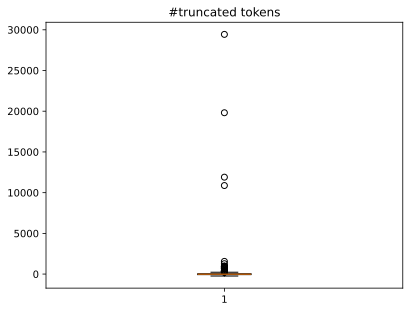

In [ ]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

max_num_tokens = 256 # @param

num_chars, num_tokens = [], []

for i, text in enumerate(train_dataset['text']):
  text = prompt + text
  num_tokens.append(len(tokenizer.tokenize(text)))
  num_chars.append(len(text))

num_chars = np.array(num_chars)
num_tokens = np.array(num_tokens)
print('Median #chars', np.median(num_chars))
print('Max #chars', np.max(num_chars))
print('Median #tokens', np.median(num_tokens))
print('Max #tokens', np.max(num_tokens))
num_truncations = np.sum(num_tokens > max_num_tokens)
num_truncated_tokens = num_tokens - max_num_tokens
median_num_truncated_tokens = np.median(
    np.where(num_truncated_tokens > 0, num_truncated_tokens, 0),
)
print(f'Number of examples that will be truncated: {num_truncations} ({num_truncations/len(num_tokens) * 100:.2f} %)')
plt.boxplot(num_truncated_tokens)
plt.title('#truncated tokens')
plt.show()

**Discussion:** By only truncating the data we're losing A LOT of relevant text. What we could do to avoid this?

In [ ]:
# Drop empty lyrics.
train_dataset = train_dataset.filter(lambda x: len(x["text"]) > 0)
print('Here is a data example before tokenization')
print_sample(prompt, train_dataset[0]["text"])
# Add prompt
train_dataset = train_dataset.map(lambda x: {"text": prompt + x["text"]})

def tokenize(prompt):
  result = tokenizer(
      prompt,
      truncation=True,
      max_length=max_num_tokens,
      padding="max_length",
  )
  return {
      "input_ids": result["input_ids"],
      "attention_mask": result["attention_mask"],
  }

train_dataset = train_dataset.shuffle().map(lambda x: tokenize(x["text"]))

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Here is a data example before tokenization


Map:   0%|          | 0/494 [00:00<?, ? examples/s]

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

## Finetune a model with LORA

Below we fine tune our model with LoRA. The first thing to do now is to set our hyperparameters for training.

In [ ]:
# @title Hyper-parameters
MICRO_BATCH_SIZE = 4 # @param
BATCH_SIZE = 32 # @param
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
EPOCHS = 40 # @param
LEARNING_RATE = 3e-4 # @param
CUTOFF_LEN = max_num_tokens
LORA_R = 12 # @param
LORA_ALPHA = 12 # @param
LORA_DROPOUT = 0.2 # @param
WARMUP_STEPS = 20 # @param
QUERY_USED_DURING_TRAINING = "Tell me about.." # @param

Now we load our model in using the PEFT library. Remember, the PEFT library is where all these optimisation and efficient training methods are created in.

**Discussion:** Do you know what each of the hyper-parameters do above? Do you understand the intution behind each of them? Try thinking about this and discussing it with your colleagues and tutors about this!

In [ ]:
peft_config = peft.LoraConfig(
    task_type=peft.TaskType.CAUSAL_LM,
    inference_mode=False,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    # Default is to apply lora to Q and V projection matrices.
    # These are based on results of Table 5 of the paper.
    target_modules=None,
)
peft_model = peft.get_peft_model(copy.deepcopy(model), peft_config)
peft_model.print_trainable_parameters()

trainable params: 1,179,648 || all params: 356,002,816 || trainable%: 0.3314


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


With all of the groundwork finally laid out, we can train our model! We are using a bit of hacking to better showcase what is happening. It is not too important to understand everything below.

In [ ]:
# --- Plotting callback ---
def run_sample(
    model,
    tokenizer,
    prompt: str,
    seed: int,
    temperature: float = 0.8,
    top_p: float = 0.9,
):
    torch.manual_seed(seed)

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    with torch.no_grad():
        output = model.generate(
            input_ids=input_ids,
            max_length=CUTOFF_LEN, # Use CUTOFF_LEN from defined hyperparameters
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
        )
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    clear_output()
    print_sample(prompt, generated_text, model_name=model.config._name_or_path)
class PlotLossCallback(transformers.TrainerCallback):
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def on_epoch_end(self, args, state, control, logs=None, **kwargs):
        train_losses, eval_losses, learning_rates, steps = [], [], [], []
        for curr_state in state.log_history:
            if "loss" in curr_state:
                train_losses.append(curr_state["loss"])
                steps.append(curr_state.get("step", len(steps)))
            if "eval_loss" in curr_state:
                eval_losses.append(curr_state["eval_loss"])
            if "learning_rate" in curr_state:
                 learning_rates.append(curr_state["learning_rate"])


        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
        ax1.plot(steps[:len(train_losses)], train_losses, "-o", label="Train Loss")
        if eval_losses:
            ax1.plot(steps[:len(eval_losses)], eval_losses, "-o", label="Validation Loss")
            ax1.legend()
        ax1.set_title("Steps vs Loss")
        ax1.set_xlabel("Step")
        ax1.set_ylabel("Loss")

        ax2.plot(steps[:len(learning_rates)], learning_rates, "-o")
        ax2.set_title("Step vs Learning Rate")
        ax2.set_xlabel("Step")
        ax2.set_ylabel("Learning rate")
        plt.show()

        # Run sample generation at the end of each epoch
        _ = run_sample(
            self.model,
            self.tokenizer,
            prompt=prompt + QUERY_USED_DURING_TRAINING,
            seed=1,
            temperature=0.8,
            top_p=0.9,
        )


# --- Hacky trainer that runs a sample during eval ---
class HackyTrainerThatRunsSampleInTheLoop(transformers.Trainer):
    def prediction_step(
        self,
        model,
        inputs,
        prediction_loss_only: bool,
        ignore_keys: list[str] | None = None,
    ):
        # Call the parent class's prediction_step to compute the loss
        loss, logits, labels = super().prediction_step(
            model, inputs, prediction_loss_only=prediction_loss_only, ignore_keys=ignore_keys
        )

        return (loss, logits, labels)

training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=10,
    output_dir="tmp",
    save_strategy="no",
    eval_strategy="epoch",
    logging_strategy="epoch",
    report_to="none",
)

# Split the dataset into training and validation sets
train_dataset_split, eval_dataset_split = train_dataset.train_test_split(test_size=0.1).values()


trainer = HackyTrainerThatRunsSampleInTheLoop(
    model=peft_model,
    train_dataset=train_dataset_split,
    eval_dataset=eval_dataset_split,
    args=training_arguments,
    callbacks=[PlotLossCallback(model=peft_model, tokenizer=tokenizer)],  # pass an instance
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    tokenizer=tokenizer,
)

peft_model.config.use_cache = False
trainer.train(resume_from_checkpoint=False)

Epoch,Training Loss,Validation Loss
1,2.746100,2.545077
2,2.520800,2.477201
3,2.428900,2.425149
4,2.360600,2.363835
5,2.288000,2.317809
6,2.238300,2.282211
7,2.205400,2.266683
8,2.183100,2.257880
9,2.165200,2.248238
10,2.149700,2.244113


TrainOutput(global_step=560, training_loss=2.1041604689189364, metrics={'train_runtime': 1362.7743, 'train_samples_per_second': 13.032, 'train_steps_per_second': 0.411, 'total_flos': 8279042209873920.0, 'train_loss': 2.1041604689189364, 'epoch': 40.0})

### ⏰⚡ Demo Time with our trained model🚀😰

In [ ]:
seed = 2
query = "Today"
final_prompt = prompt + query
temperature = 1.0
top_p = 0.9
print('LoRA model')
_ = run_sample(
    peft_model,
    tokenizer,
    prompt=final_prompt,
    seed=seed,
    temperature=temperature,
    top_p=top_p,
)


In [ ]:

print('Original model')
_ = run_sample(
    model,
    tokenizer,
    prompt=final_prompt,
    seed=seed,
    temperature=temperature,
    top_p=top_p,
)

That's it, you've been able to finetune an LLM to generate lyrics from a an artist, look at the response between the LoRA model and the Original model, are you able to spot any differences and if so, can you explain?